# Decision Tree
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using Decision Tree to classify the data points on the target ("Outcome" of the stop and search).

In [72]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, roc_auc_score

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [74]:
police_actions_simple = ["Article Found", "Resolved", "Nothing",
                         "Cautioned", "Drug Warning", "Penalty Notice", "Arrested", "Summonsed"]

def evaluate(model, X_train, y_train, X_test, y_test, target_classes=police_actions_simple, average='weighted', binary=False, rotation=90, fontsize=18):
    print(f"Accurancy Score (Train): {int(np.around(model.score(X_train, y_train), 2) * 100)}%")
    print(f"Accuracy Score (Test): {int(np.around(model.score(X_test, y_test), 2) * 100)}%")
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    print(f"\nPrecision Score (Train): {int(np.around(precision_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Precision Score (Test): {int(np.around(precision_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nRecall Score (Train): {int(np.around(recall_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"Recall Score (Test): {int(np.around(recall_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nF1 Score (Train): {int(np.around(f1_score(y_train, y_train_predictions, average=average), 2) * 100)}%")
    print(f"F1 Score (Test): {int(np.around(f1_score(y_test, y_test_predictions, average=average), 2) * 100)}%")
    print(f"\nMCC (Train): {matthews_corrcoef(y_train, y_train_predictions)}")
    print(f"MCC (Test): {matthews_corrcoef(y_test, y_test_predictions)}")
    print("\n Confusion Matrix")
    if binary:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=["No Action", "Action"], rotation=rotation, fontsize=fontsize)
    else:
        util.confusion_plot(y_test=y_test, y_predictions=y_test_predictions, target_classes=target_classes, rotation=rotation, fontsize=fontsize)

## Cleaning the Data set

In [76]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values

In [78]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split the data into train and test

In [80]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## Train the Decision Tree

In [82]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Accurancy Score (Train): 99%
Accuracy Score (Test): 54%

Precision Score (Train): 99%
Precision Score (Test): 54%

Recall Score (Train): 99%
Recall Score (Test): 54%

F1 Score (Train): 99%
F1 Score (Test): 54%

MCC (Train): 0.9768761494426926
MCC (Test): 0.11398283850157463

 Confusion Matrix


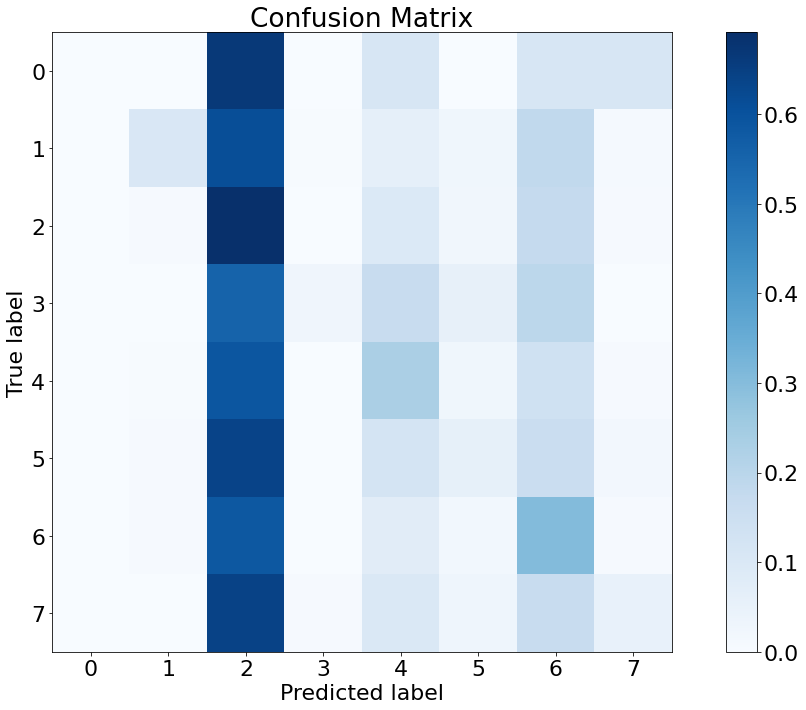

In [83]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Large discrepency between the training score and testing score indicates large overfitting of the data, I will prune the data.

## Prune and visualisation

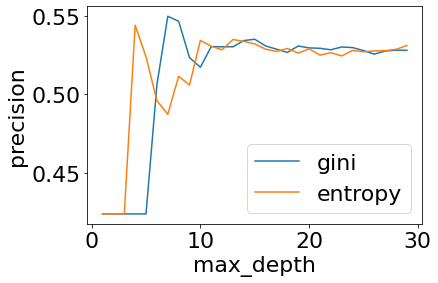

In [135]:
#Simple function to run our model using different values for max_depth (from 1 to 30) and visualise its results to see how the precision differs for each value.
#Visualisation technique from: https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752


max_depth = []
precision_gini = []
precision_entropy = []
for i in range(1,30):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 precision_gini.append(precision_score(y_test, pred, average='weighted'))
 ####
 dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 precision_entropy.append(precision_score(y_test, pred, average='weighted'))
 ####
 max_depth.append(i)
d = pd.DataFrame({'precision_gini':pd.Series(precision_gini), 
 'precision_entropy':pd.Series(precision_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','precision_gini', data=d, label='gini')
plt.plot('max_depth','precision_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('precision')
plt.legend()

It seems like in this scenario gini and entropy both work best for larger trees, but gini has a higher peak for smaller trees. So let’s first draw the tree with max_depth=6 and criterion=gini to see how it looks like.

In [85]:
ptree = DecisionTreeClassifier(criterion='gini', max_depth=6)
ptree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 66%
Accuracy Score (Test): 65%

Precision Score (Train): 63%
Precision Score (Test): 51%

Recall Score (Train): 66%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.03103203442310589
MCC (Test): 0.009789287268286732

 Confusion Matrix


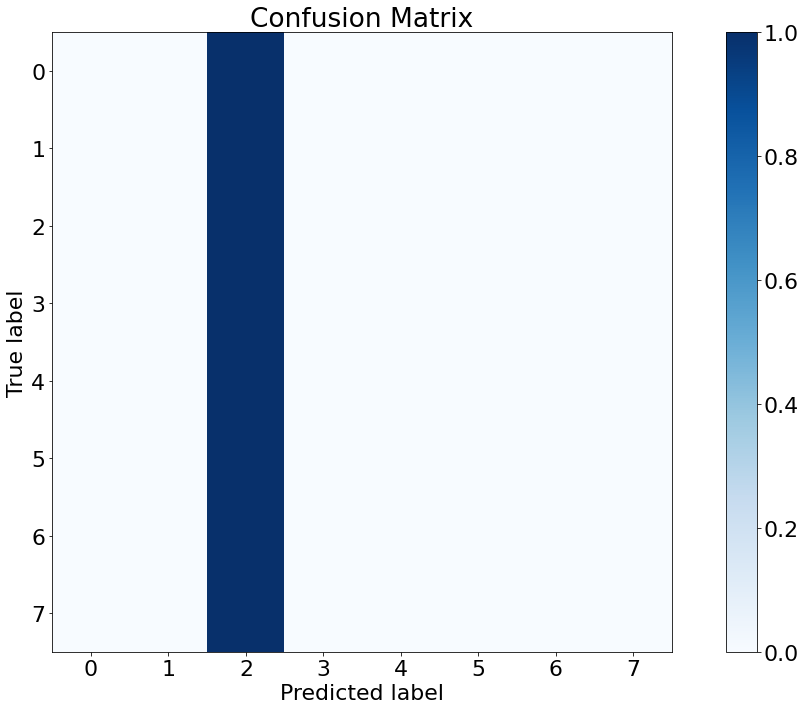

In [86]:
evaluate(model=ptree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

The Decision Tree appears to be very biased towards predicting Nothing. I will try the more stable max_depth of 20.

In [87]:
ptree = DecisionTreeClassifier(criterion='gini', max_depth=20)
ptree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 75%
Accuracy Score (Test): 62%

Precision Score (Train): 79%
Precision Score (Test): 53%

Recall Score (Train): 75%
Recall Score (Test): 62%

F1 Score (Train): 70%
F1 Score (Test): 55%

MCC (Train): 0.46029442621620825
MCC (Test): 0.07374540102825443

 Confusion Matrix


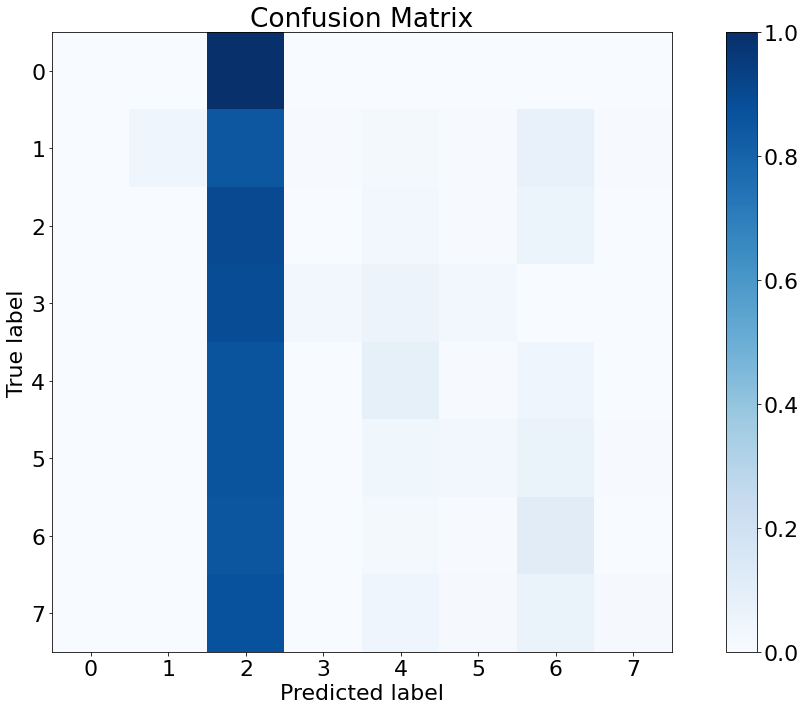

In [88]:
evaluate(model=ptree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Much better precision score but still appears to be biased to predicting Nothing.

## Preprocessing

In [89]:
#Preprocessing technique from Exercise 2 Part 2
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [90]:
#Preproccesing technique from lecture 2 to normalise the data
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [91]:
tree_std = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree_std.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 66%
Accuracy Score (Test): 65%

Precision Score (Train): 63%
Precision Score (Test): 51%

Recall Score (Train): 66%
Recall Score (Test): 65%

F1 Score (Train): 52%
F1 Score (Test): 51%

MCC (Train): 0.03103203442310589
MCC (Test): 0.009789287268286732

 Confusion Matrix


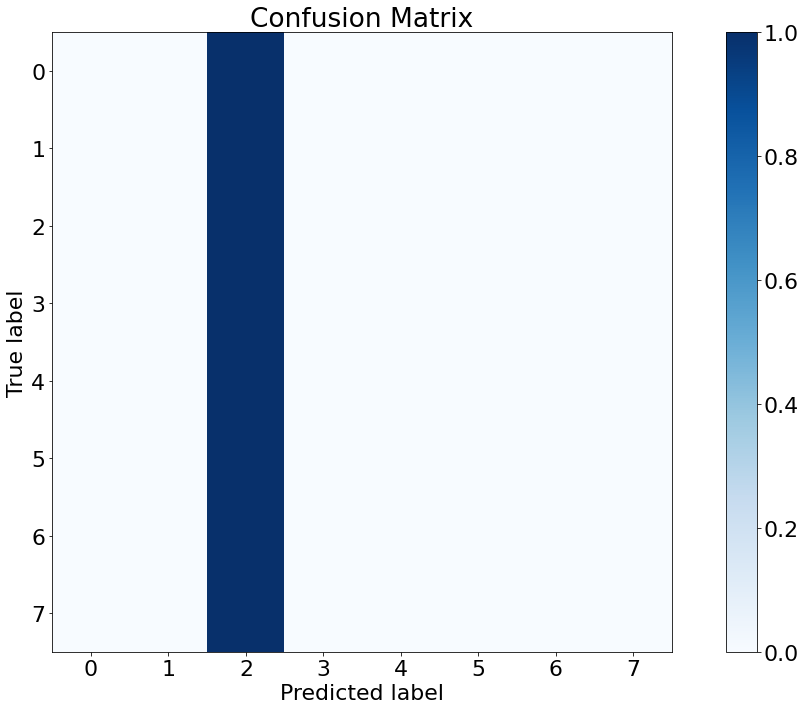

In [92]:
evaluate(model=tree_std, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

In [93]:
tree_std = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree_std.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 75%
Accuracy Score (Test): 62%

Precision Score (Train): 79%
Precision Score (Test): 53%

Recall Score (Train): 75%
Recall Score (Test): 62%

F1 Score (Train): 70%
F1 Score (Test): 55%

MCC (Train): 0.4624719392223185
MCC (Test): 0.07432767520770106

 Confusion Matrix


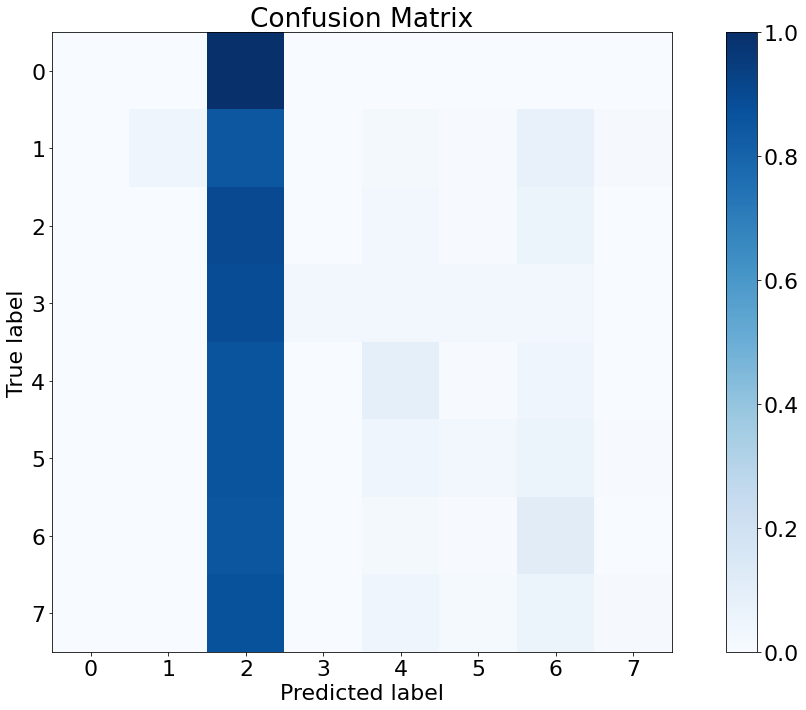

In [94]:
evaluate(model=tree_std, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Both decision trees are identical ones with the same hyperparameters and no preprocessing. I will try K-Fold instead.

## Training Using K-Fold Cross Validation

In [95]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
tree_kfold = DecisionTreeClassifier(criterion='gini', max_depth=6)
util.k_fold_train(model=tree_kfold, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6543414830465841
Accuracy (Test): 0.6543414830465841
Precision (Train): 0.6219409475490892
Precision (Test): 0.6219409475490892
MCC (Train): 0.027375625909306332
MCC (Test): 0.027375625909306332

Fold #2, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6557836133749203
Accuracy (Test): 0.6557836133749203
Precision (Train): 0.6570207817155871
Precision (Test): 0.6570207817155871
MCC (Train): 0.028759550135750253
MCC (Test): 0.028759550135750253

Fold #3, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6541570245162156
Accuracy (Test): 0.6541570245162156
Precision (Train): 0.6057932297195194
Precision (Test): 0.6057932297195194
MCC (Train): 0.025868808425865183
MCC (Test): 0.025868808425865183

Fold #4, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.6550541637320991
Accuracy (Test): 0.6550541637320991
Pre

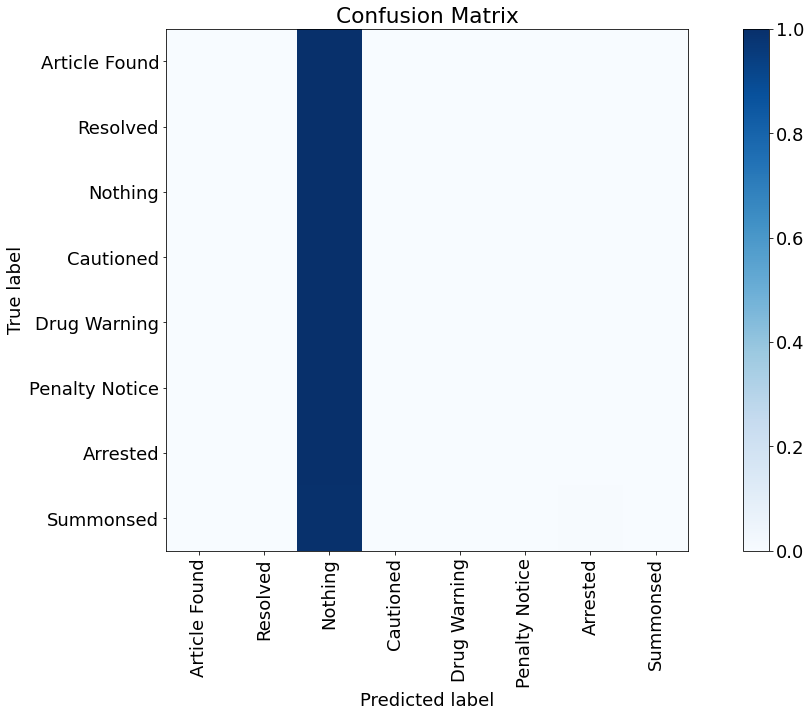

In [96]:
y_predict_k = tree_kfold.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k)

In [97]:
tree_kfold = DecisionTreeClassifier(criterion='gini', max_depth=20)
util.k_fold_train(model=tree_kfold, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7559781332796727
Accuracy (Test): 0.7559781332796727
Precision (Train): 0.7933323991461326
Precision (Test): 0.7933323991461326
MCC (Train): 0.4793117359044447
MCC (Test): 0.4793117359044447

Fold #2, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7461682932555254
Accuracy (Test): 0.7461682932555254
Precision (Train): 0.7864840731182965
Precision (Test): 0.7864840731182965
MCC (Train): 0.45109048747027775
MCC (Test): 0.45109048747027775

Fold #3, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.750285072274206
Accuracy (Test): 0.750285072274206
Precision (Train): 0.7919906052879814
Precision (Test): 0.7919906052879814
MCC (Train): 0.46524696779122565
MCC (Test): 0.46524696779122565

Fold #4, Training Size: 119268, Validation Size: 29817
Accuracy (Train): 0.7477529597209646
Accuracy (Test): 0.7477529597209646
Precision (Tr

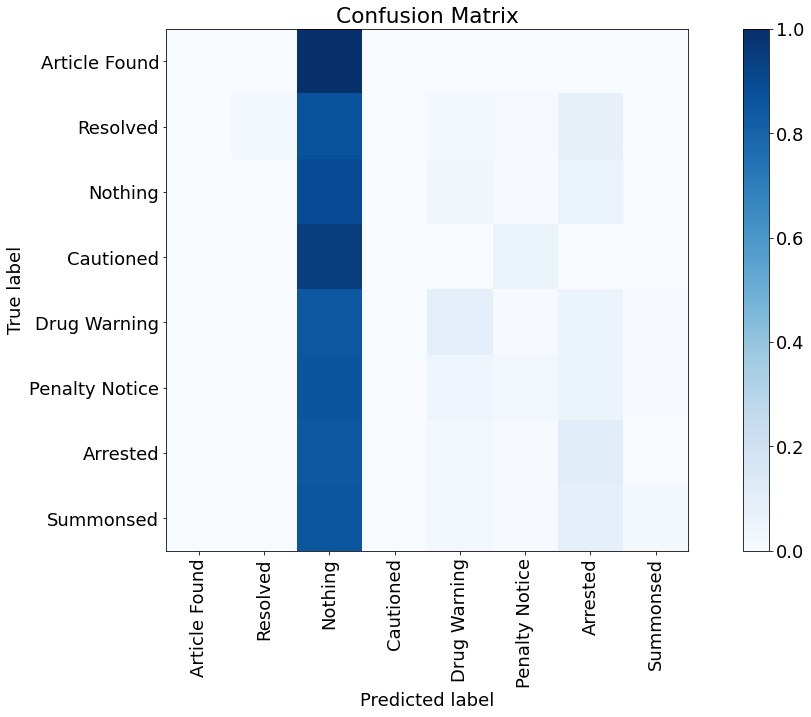

In [98]:
y_predict_k = tree_kfold.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k)

## Using SMOTE
We use SMOTE to even out the unbalanced datasetm should I use the preprocessed data?

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


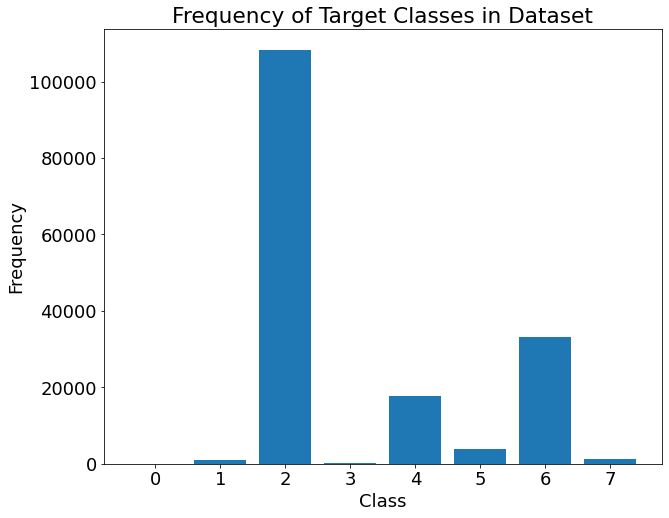

In [99]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


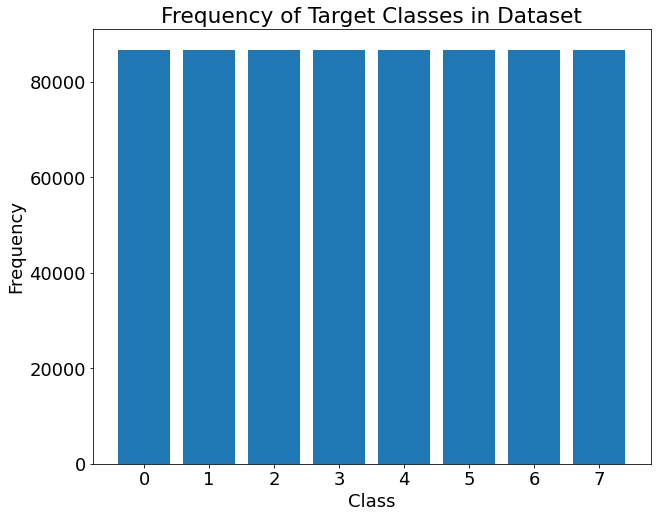

In [100]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
usm.display_frequencies(y_smote)

In [101]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 10%
Accuracy Score (Test): 9%

Precision Score (Train): 52%
Precision Score (Test): 52%

Recall Score (Train): 10%
Recall Score (Test): 9%

F1 Score (Train): 7%
F1 Score (Test): 6%

MCC (Train): 0.052753318950864554
MCC (Test): 0.0487823556558877

 Confusion Matrix


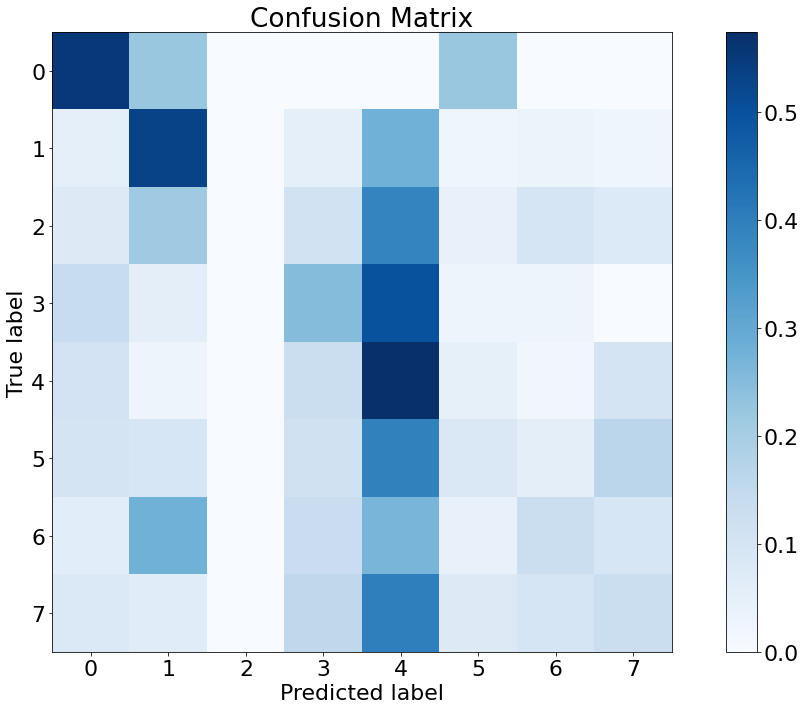

In [102]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

In [103]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 47%
Accuracy Score (Test): 28%

Precision Score (Train): 74%
Precision Score (Test): 53%

Recall Score (Train): 47%
Recall Score (Test): 28%

F1 Score (Train): 54%
F1 Score (Test): 35%

MCC (Train): 0.3260982383599045
MCC (Test): 0.07430595869363119

 Confusion Matrix


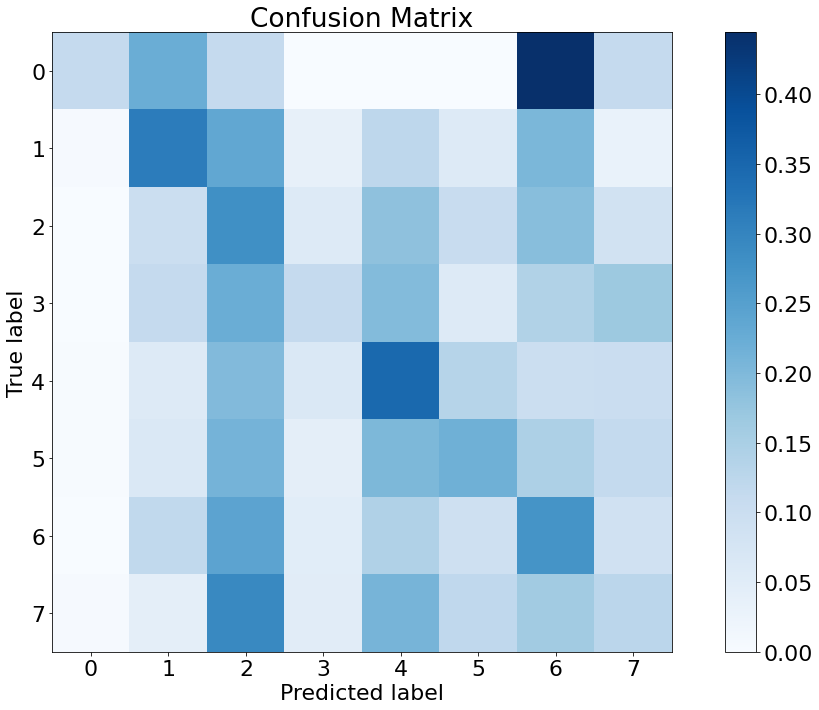

In [104]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Most well balanced confusion matrix so far,and good precision score.

## Using Biased SMOTE
We over sample minority classes, but not to an extent that equalizes them to the majority class

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


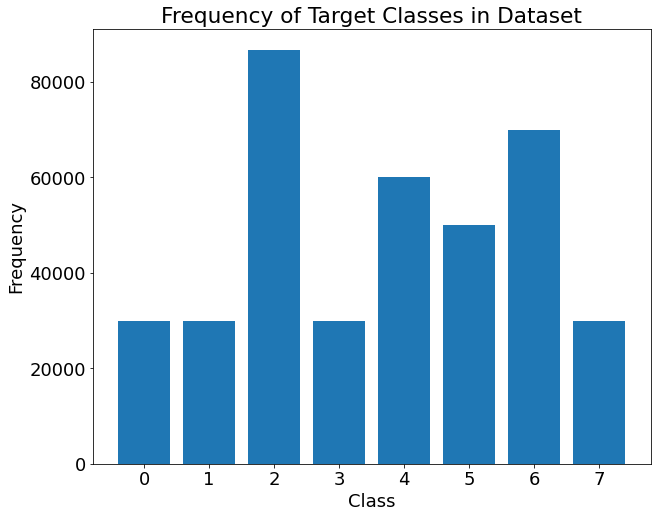

In [105]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [106]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=6)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=6)

Accurancy Score (Train): 33%
Accuracy Score (Test): 33%

Precision Score (Train): 52%
Precision Score (Test): 52%

Recall Score (Train): 33%
Recall Score (Test): 33%

F1 Score (Train): 37%
F1 Score (Test): 37%

MCC (Train): 0.08247900668825649
MCC (Test): 0.08228780545665182

 Confusion Matrix


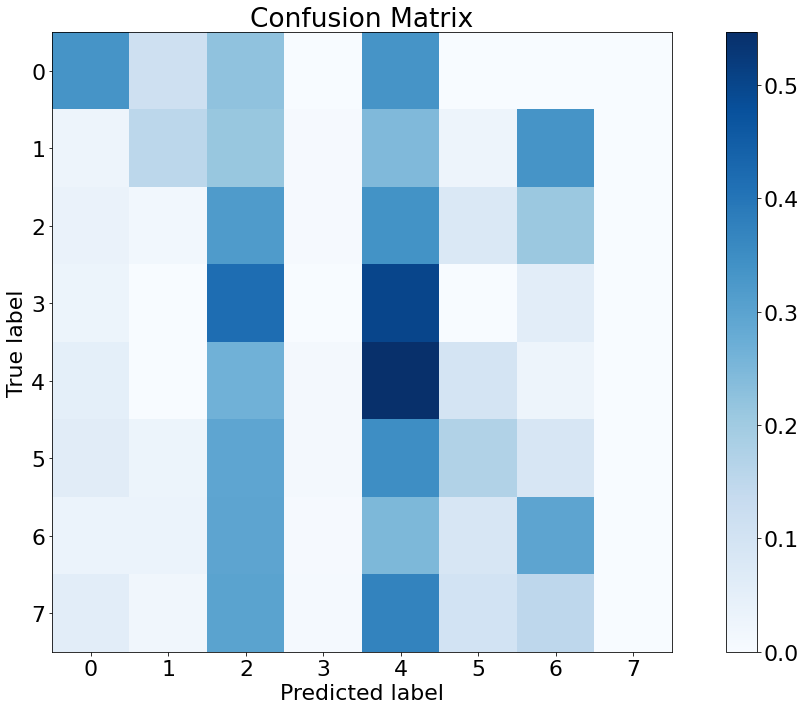

In [107]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

This yields identical confusion matrix and results as without biased SMOTE.

In [108]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=20)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=20)

Accurancy Score (Train): 56%
Accuracy Score (Test): 38%

Precision Score (Train): 71%
Precision Score (Test): 52%

Recall Score (Train): 56%
Recall Score (Test): 38%

F1 Score (Train): 61%
F1 Score (Test): 43%

MCC (Train): 0.3608117180845397
MCC (Test): 0.08219644095728489

 Confusion Matrix


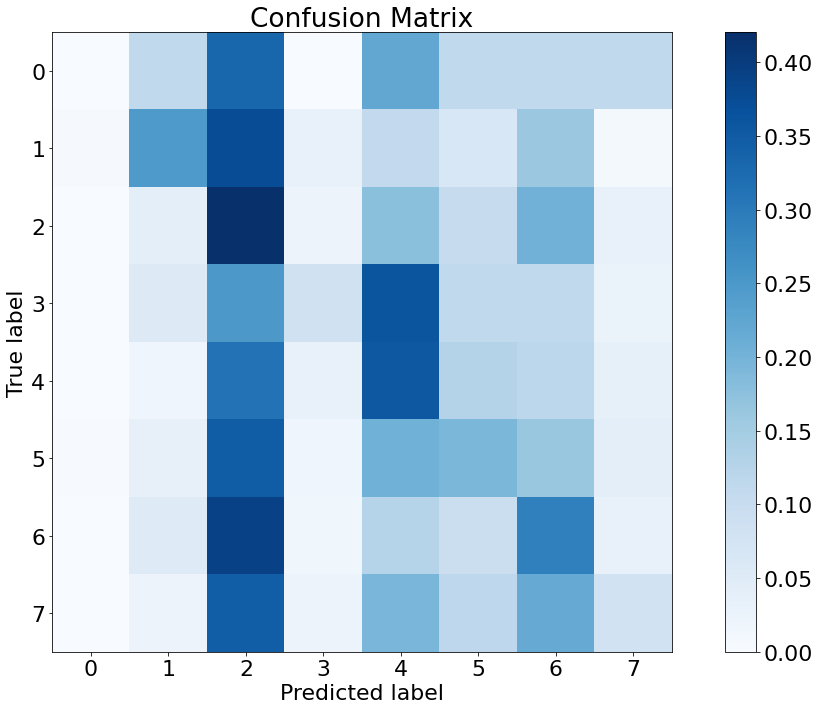

In [109]:
evaluate(model=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Slightly less balanced compared to the model with using just SMOTE.

## Bootstrap Aggregating

In [110]:
bagging = BaggingClassifier()
bagging.fit(X_train, y_train)

BaggingClassifier()

Accurancy Score (Train): 95%
Accuracy Score (Test): 59%

Precision Score (Train): 95%
Precision Score (Test): 54%

Recall Score (Train): 95%
Recall Score (Test): 59%

F1 Score (Train): 95%
F1 Score (Test): 56%

MCC (Train): 0.9055346392783635
MCC (Test): 0.11519780779923675

 Confusion Matrix


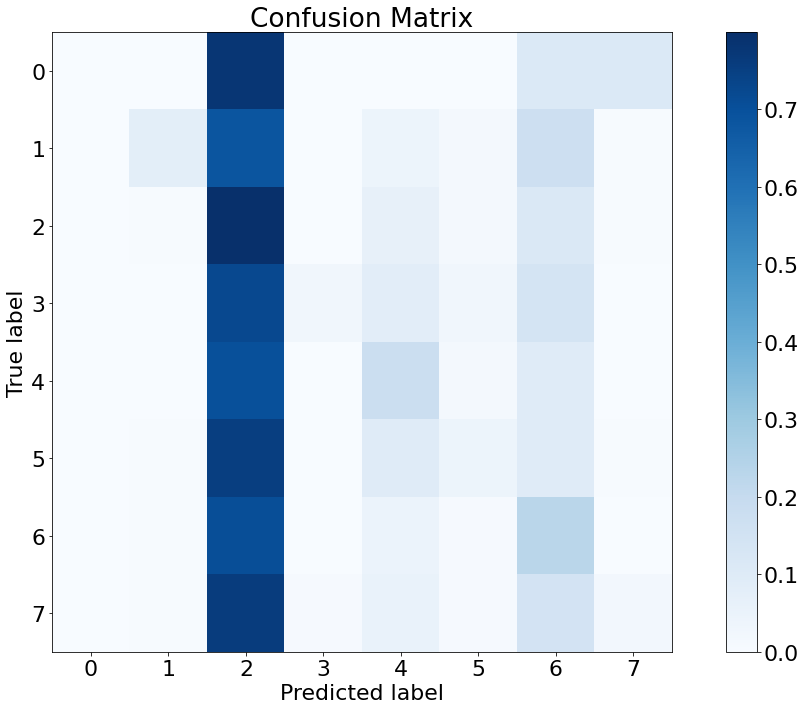

In [111]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Very similar results to the raw decision tree, rather than pruning and using K-Fold, I will go straight to using the same SMOTE process as I did for the decision tree.

In [112]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 96%
Accuracy Score (Test): 44%

Precision Score (Train): 96%
Precision Score (Test): 54%

Recall Score (Train): 96%
Recall Score (Test): 44%

F1 Score (Train): 96%
F1 Score (Test): 48%

MCC (Train): 0.9160774737615663
MCC (Test): 0.10095194837355607

 Confusion Matrix


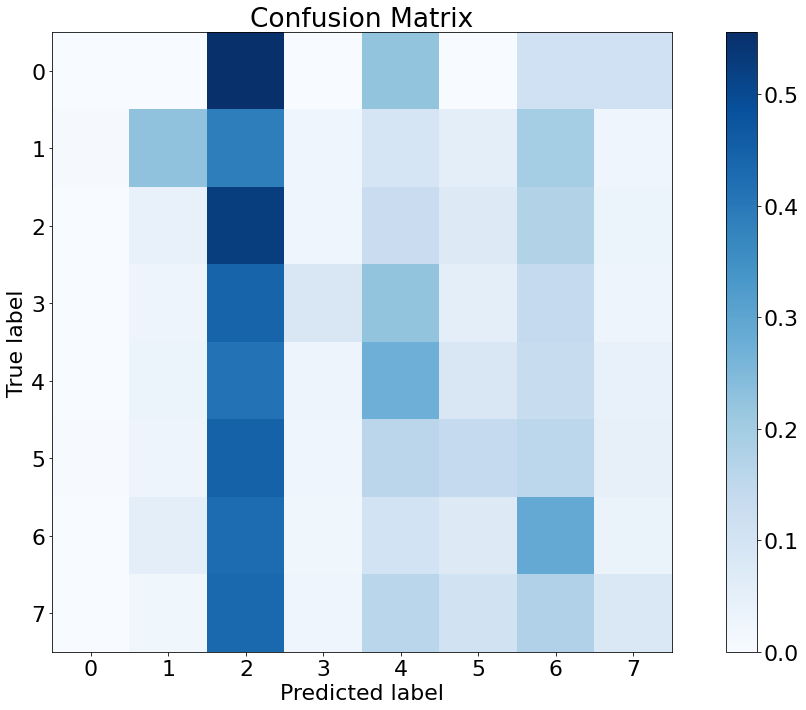

In [113]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Much more balanced confusion matrix, however there still appears to be oversampling. Perhaps Biased SMOTE will solve this.

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


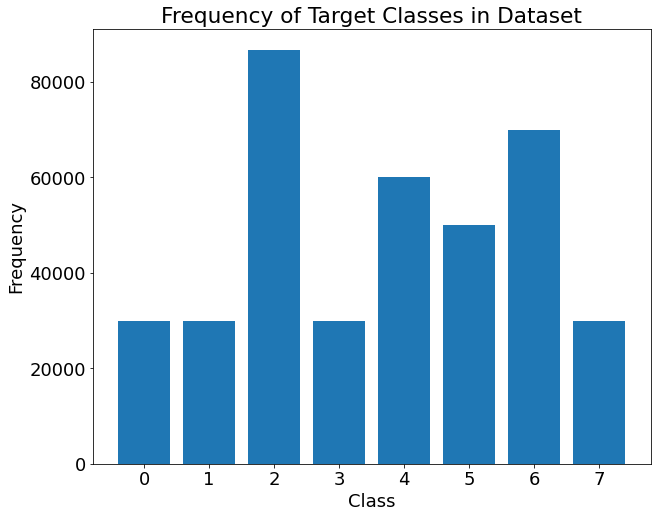

In [114]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [115]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 96%
Accuracy Score (Test): 44%

Precision Score (Train): 96%
Precision Score (Test): 54%

Recall Score (Train): 96%
Recall Score (Test): 44%

F1 Score (Train): 96%
F1 Score (Test): 48%

MCC (Train): 0.9152995273633983
MCC (Test): 0.10775191248887434

 Confusion Matrix


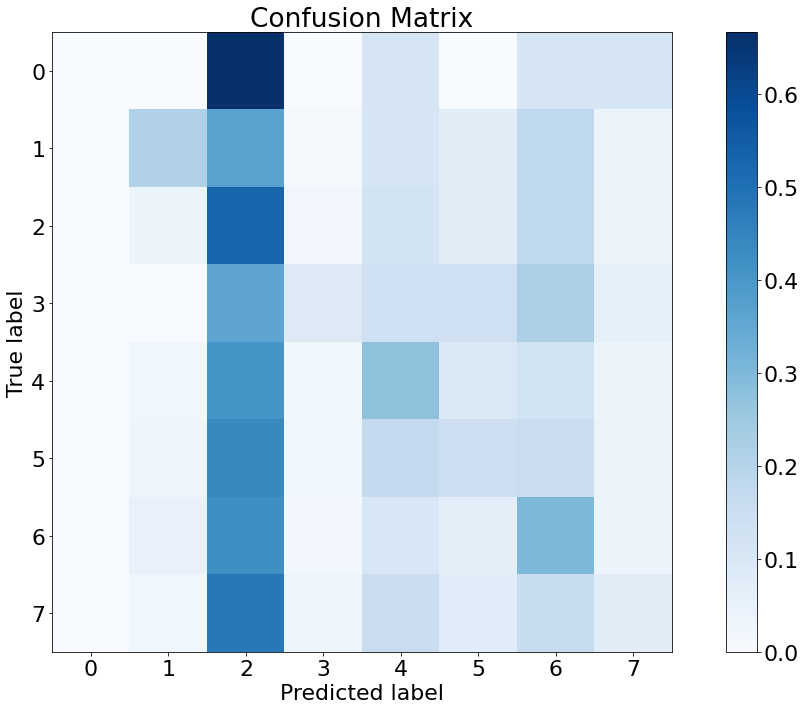

In [116]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Model is very biased towards predicting arrested as an outcome. I will lower the frequency of class six.

Class 0: 8.65%     (30000)
Class 1: 8.65%     (30000)
Class 2: 25.03%     (86784)
Class 3: 8.65%     (30000)
Class 4: 17.3%     (60000)
Class 5: 14.42%     (50000)
Class 6: 8.65%     (30000)
Class 7: 8.65%     (30000)
Total: 346784


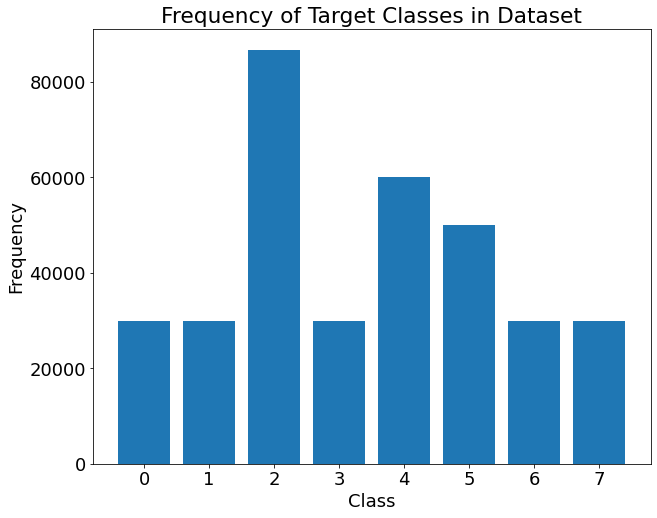

In [117]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:30000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [118]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Accurancy Score (Train): 95%
Accuracy Score (Test): 46%

Precision Score (Train): 96%
Precision Score (Test): 55%

Recall Score (Train): 95%
Recall Score (Test): 46%

F1 Score (Train): 95%
F1 Score (Test): 49%

MCC (Train): 0.9074150710259412
MCC (Test): 0.1028812556750003

 Confusion Matrix


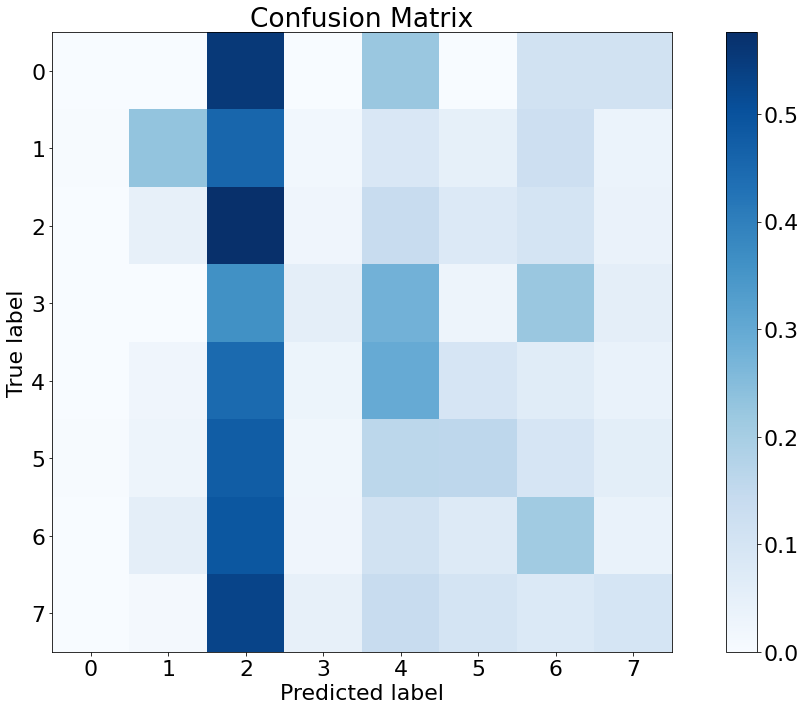

In [119]:
evaluate(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Slightly better confusion matrix

## Random Forests

[0.517956807254605, 0.5267765834642353, 0.528064492701902, 0.5300090416852504, 0.5284915534413682, 0.5333489320385086, 0.5333455426342244, 0.5348699195942902, 0.5358883173493376, 0.5335525117212279, 0.5325432100843166, 0.5334277796903409, 0.5375897871641729, 0.5341568520165244, 0.5360191678205282, 0.5366557923322529, 0.5351918170977599, 0.5354857961150229, 0.5352187142093745, 0.5380503536848384, 0.5352786092823275, 0.5399348953495351, 0.5356404770381802, 0.5344537159176109, 0.5378824292218751, 0.5366906854644266, 0.5363928636676379, 0.5373934049723484, 0.5343144066010778, 0.5357067022646822, 0.5369748504257555, 0.5390225810572129, 0.5377559515307694, 0.5368493980749027, 0.5362195181296526, 0.5371621649820851, 0.5363262290025377, 0.5362947174294583, 0.5383260890750015, 0.5379596666008013, 0.5375786886660792, 0.5368774462214366, 0.5375785433326644, 0.5378645157898315, 0.5376915252137018, 0.5378427047643771, 0.5396081977434021, 0.5380164618684667, 0.537507822626919, 0.5369217753782267, 0.

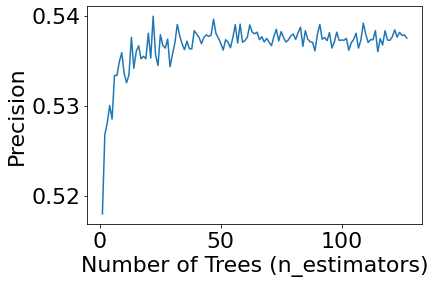

In [136]:
# Investigates the precision over a range of estimators plotting the result
# Same function used in exercise 5 part 2
precision_data = []
nums = []
for i in range(1,128):
    rf_model = RandomForestClassifier(n_estimators=i,criterion="entropy")
    rf_model.fit(X_train, y_train)
    y_model = rf_model.predict(X_test)
    precision = precision_score(y_test, y_model, average='weighted')
    precision_data.append(precision)
    nums.append(i)
    
print(precision_data)
plt.plot(nums,precision_data)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Precision")
plt.show()

The graph indicates that the most stable precision occurs at around 100 n_estimators, which is the default.

In [121]:
rf_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

Accurancy Score (Train): 99%
Accuracy Score (Test): 57%

Precision Score (Train): 99%
Precision Score (Test): 54%

Recall Score (Train): 99%
Recall Score (Test): 57%

F1 Score (Train): 99%
F1 Score (Test): 55%

MCC (Train): 0.9765355834551035
MCC (Test): 0.1108068650078319

 Confusion Matrix


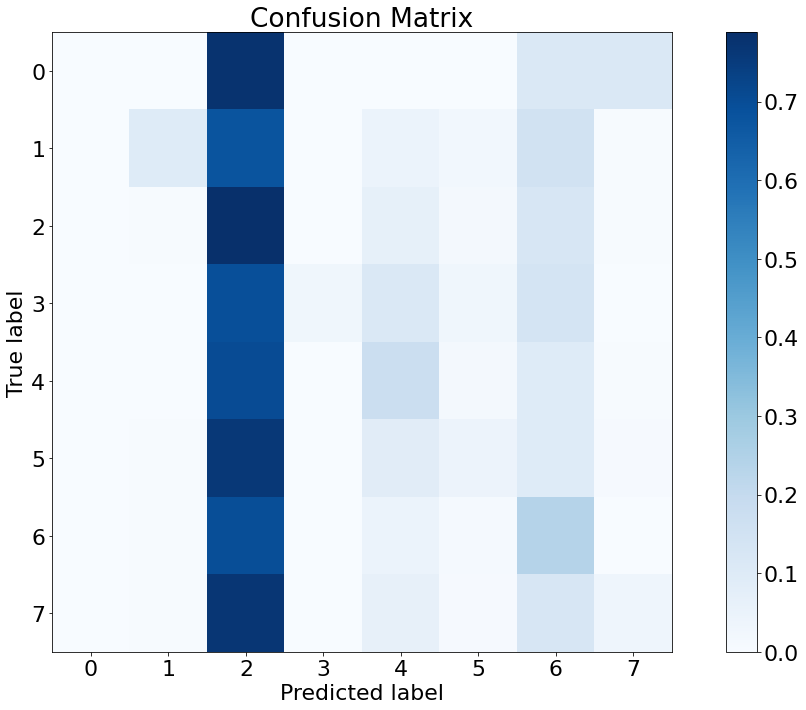

In [122]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

Similarly to Bagging, I shall use SMOTE to reduce the overfitting and balance the confusion matrix.

In [123]:
rf_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy')

Accurancy Score (Train): 99%
Accuracy Score (Test): 46%

Precision Score (Train): 99%
Precision Score (Test): 55%

Recall Score (Train): 99%
Recall Score (Test): 46%

F1 Score (Train): 99%
F1 Score (Test): 50%

MCC (Train): 0.9765990545587903
MCC (Test): 0.10550897013084425

 Confusion Matrix


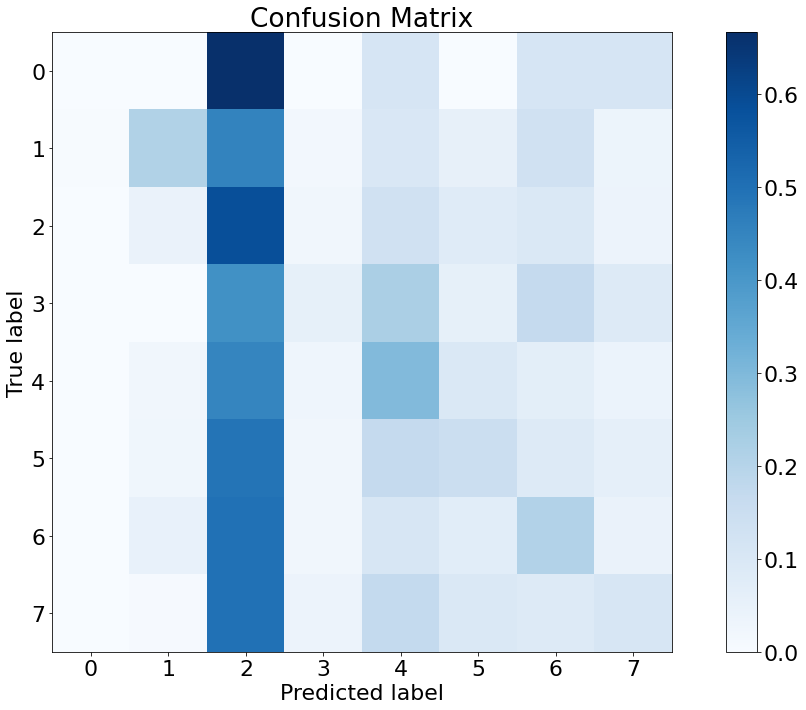

In [124]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

This model produces very good evaluation scores, but once again the confusion matrix isn't as balanced as the Decision Tree matrix

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


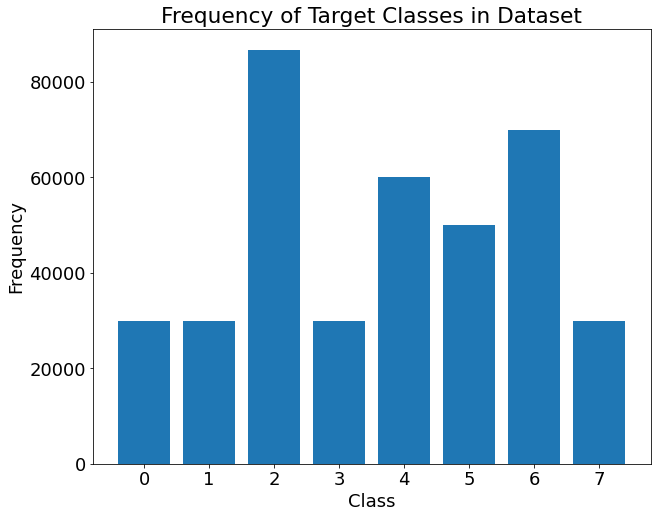

In [125]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train, y_train, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [126]:
rf_model = RandomForestClassifier(criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy')

Accurancy Score (Train): 99%
Accuracy Score (Test): 45%

Precision Score (Train): 99%
Precision Score (Test): 55%

Recall Score (Train): 99%
Recall Score (Test): 45%

F1 Score (Train): 99%
F1 Score (Test): 49%

MCC (Train): 0.9764632217120337
MCC (Test): 0.11372041382052941

 Confusion Matrix


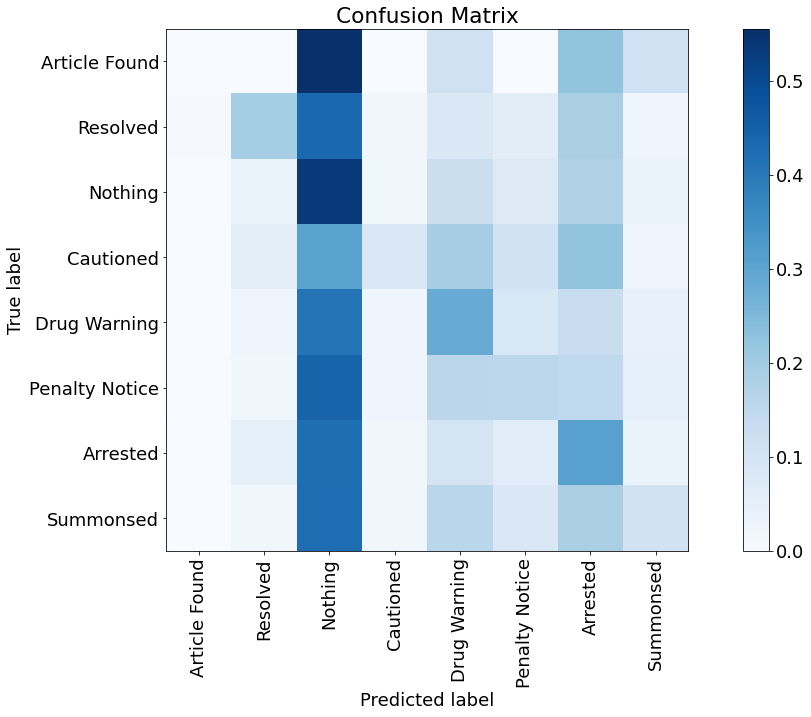

In [127]:
evaluate(model=rf_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, average="weighted")

## Using Grid Search to Tune Hyperparamaters
The most well balanced confusion matrix out of all the tree models was the first Decision Tree using smoting, so I will use Grid Search on a Decision Tree.

In [128]:
X_smote, y_smote = usm.smote_data(X_train, y_train)

In [129]:
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
decision_tree_search = GridSearchCV(DecisionTreeClassifier(), tree_param, verbose=1, cv=3, scoring="precision_weighted", n_jobs=-1)
decision_tree_search.fit(X_smote, y_smote)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.4min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring='precision_weighted', verbose=1)

Accurancy Score (Train): 87%
Accuracy Score (Test): 37%

Precision Score (Train): 92%
Precision Score (Test): 54%

Recall Score (Train): 87%
Recall Score (Test): 37%

F1 Score (Train): 89%
F1 Score (Test): 43%

MCC (Train): 0.7749706623475008
MCC (Test): 0.09164150761594102

 Confusion Matrix


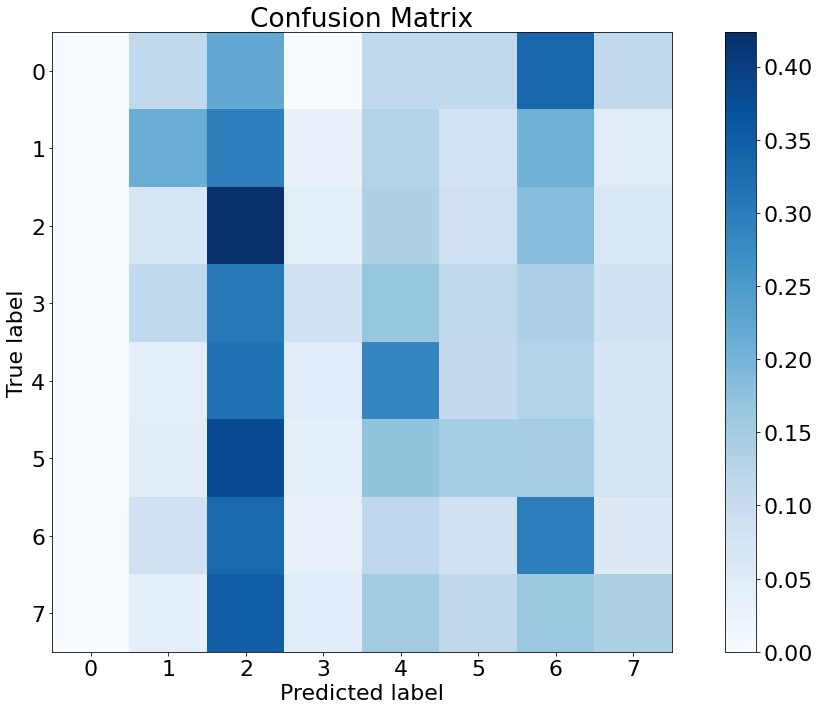

In [130]:
evaluate(model=decision_tree_search.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

In [131]:
print(decision_tree_search.best_params_)

{'criterion': 'gini', 'max_depth': 30}


A balanced confusion matrix but not as balanced as the smoted Decision Tree with max depth twenty, appears to be that Grid Search looks for best precision rather than balanced matrix.

## Grid Search for Matthew's Correlation Coefficient

In [132]:
from sklearn.metrics import make_scorer
#From https://scikit-learn.org/stable/modules/model_evaluation.html#scoring 
scorer = make_scorer(matthews_corrcoef)

tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
decision_tree_search = GridSearchCV(DecisionTreeClassifier(), tree_param, verbose=1, cv=3, scoring=scorer, n_jobs=-1)
decision_tree_search.fit(X_smote, y_smote)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.6min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

Accurancy Score (Train): 87%
Accuracy Score (Test): 37%

Precision Score (Train): 92%
Precision Score (Test): 54%

Recall Score (Train): 87%
Recall Score (Test): 37%

F1 Score (Train): 89%
F1 Score (Test): 43%

MCC (Train): 0.775207133988582
MCC (Test): 0.09064683626267798

 Confusion Matrix


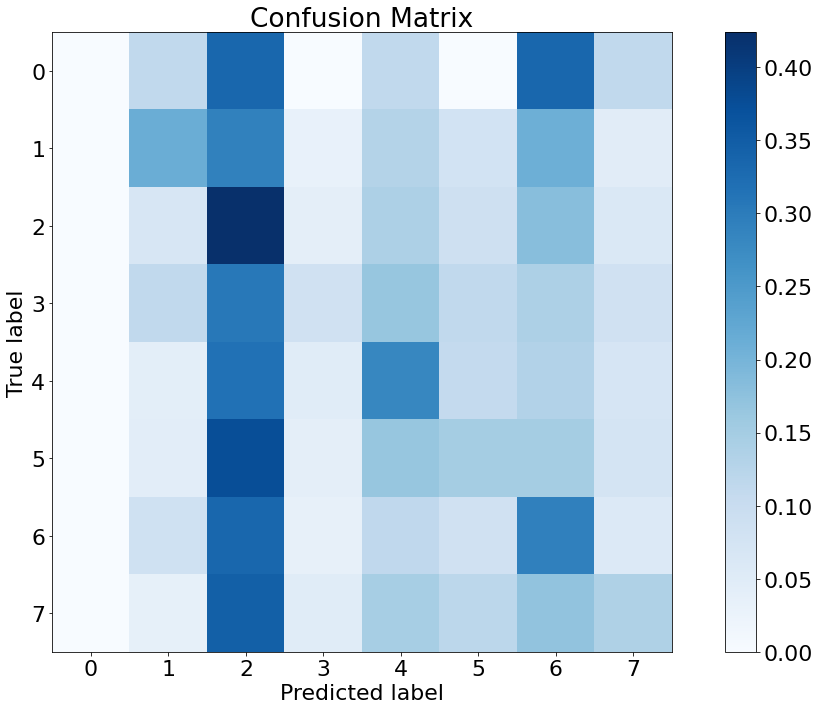

In [133]:
evaluate(model=decision_tree_search.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target_classes=[0, 1, 2, 3, 4, 5, 6, 7], rotation=0, fontsize=22)

In [134]:
print(decision_tree_search.best_params_)

{'criterion': 'gini', 'max_depth': 30}
